# Final Project in Text Analysis and Natural Language Processing

### Title: Predicting financial risk using NLP, a sentiment and entity based approach

#### Table of contents:


<a href='#web_scrape'>1. Webscraping the data from the Google News </a><br>
    
<a href='#data_cleaning'>2. Text Cleaning & Deduplication</a>

<a href='#text_pre'>3. Text Preprocessing</a>	

<a href='#sent_ana'>4. Sentiment Analysis with VADER </a>

<a href='#fin_ana'>5. Sentiment Analysis with FinBERT </a>

### Importing the needed libraries

Here we are importing the libraries that I will be needing for the further analysis:

In [ ]:
# Importing libraries to scrap

from serpapi import GoogleSearch
import pandas as pd
from datetime import datetime, timedelta
import time
import re

# Importing libraries for text preprocossing 
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Importing library for VADAR Sentiment Analysis
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#importin libraries for Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Importing library for FinBERT Sentiment Analysis
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
!pip install torch
!pip install torch torchvision torchaudio
import torch
from tqdm import tqdm
import requests



: 

## Webscraping the data from the Independent newspaper <a id='web_scrape'></a>

In this code snippet i have tried to scrap recent financial news headlines and a short description of the news using SerpAPI (Google News API) for the following companies:

- Apple
- Tesla
- Nvidia
- Amazon

The objective is to retrieve high-quality, recent news headlines and snippets (within the last 90 days) that can be used for further Sentiment analysis, Entity recogntion and Risk Scoring. 

In [ ]:
# ✅ Step 1: Your SerpAPI Key
API_KEY = "--"

# ✅ Step 2: Parse Relative/Absolute Dates
def parse_relative_date(text):
    today = datetime.today()
    try:
        if re.search(r"\w{3,} \d{1,2}, \d{4}", text):  # e.g. Apr 4, 2025
            return datetime.strptime(text, "%b %d, %Y")
        elif "day" in text:
            days = int(re.search(r"(\d+)", text).group(1))
            return today - timedelta(days=days)
        elif "hour" in text:
            hours = int(re.search(r"(\d+)", text).group(1))
            return today - timedelta(hours=hours)
        elif "week" in text:
            weeks = int(re.search(r"(\d+)", text).group(1))
            return today - timedelta(weeks=weeks)
        elif "month" in text:
            months = int(re.search(r"(\d+)", text).group(1))
            return today - timedelta(days=30 * months)
        else:
            return None
    except:
        return None

# ✅ Step 3: Scraper Function
def scrape_serpapi_news(company, target_articles=600):
    print(f"🔍 Scraping {company}...")
    results = []
    page = 0
    collected = 0
    today = datetime.today()
    ninety_days_ago = today - timedelta(days=90)

    while collected < target_articles:
        params = {
            "engine": "google",
            "q": f"{company} stock",
            "tbm": "nws",
            "api_key": API_KEY,
            "num": 100,
            "start": page * 100,
            "tbs": "cdr:1,cd_min:1/14/2024,cd_max:4/14/2025"
        }

        search = GoogleSearch(params)
        response = search.get_dict()
        news_results = response.get("news_results", [])

        if not news_results:
            print(f"⚠️ No more news results found at page {page} for {company}")
            break

        for article in news_results:
            pub_date_raw = article.get("date")
            parsed_date = parse_relative_date(pub_date_raw)

            if parsed_date and parsed_date >= ninety_days_ago:
                results.append({
                    "company": company,
                    "title": article.get("title"),
                    "link": article.get("link"),
                    "snippet": article.get("snippet"),
                    "source": article.get("source"),
                    "published": parsed_date.strftime("%m/%d/%Y")
                })

        collected = len(results)
        page += 1
        time.sleep(1)

    print(f"✅ Collected {len(results)} valid articles for {company}")
    return pd.DataFrame(results[:target_articles])

# ✅ Step 4: List of Companies
companies = ["Apple", "Tesla", "Nvidia", "Amazon"]

# ✅ Step 5: Scrape & Save
all_dfs = []
for company in companies:
    df = scrape_serpapi_news(company, target_articles=600)
    all_dfs.append(df)

final_df = pd.concat(all_dfs, ignore_index=True)

### Reading the data

For confidentiality purposes, i have hidden my API and have uploaded and read the data below:

In [3]:
final_df = pd.read_csv("C:\\Users\\Mustafa Ansari\\Downloads\\Scrapped Google News.csv")

In [5]:
final_df.head()

,company,title,link,snippet,source,published
0,Apple,Where Will Apple Stock Be In 5 Years?,https://www.forbes.com/sites/investor-hub/arti...,The shares currently trade approximately 12% b...,Forbes,03/15/2025
1,Apple,Apple Joins AI Data Center Race After Siri Mess,https://www.investors.com/news/technology/appl...,Apple is in the process of placing orders for ...,Investor's Business Daily,03/24/2025
2,Apple,How Bad Could Sustained Tariffs Be for Apple S...,https://www.morningstar.com/stocks/how-bad-cou...,"If tariffs persist, Apple's profit margins cou...",Morningstar,04/09/2025
3,Apple,Analysts revisit Apple stock price targets as ...,https://www.thestreet.com/investing/analysts-r...,"Wedbush analyst Dan Ives, a committed Apple bu...",TheStreet,03/24/2025
4,Apple,Watch These Apple Stock Price Levels Amid Tari...,https://www.investopedia.com/watch-these-apple...,Apple shares gained ground Wednesday after los...,Investopedia,04/09/2025


## Text Cleaning & Deduplication <a id='data_cleaning'></a>

In this step, i have firstly combined title and snippet into a single column: text then dropped exact duplicates of combined text and dropped nulls and whitespace-only entries. Finally i have reset index for tidy output.

In [4]:
# Original Data
original_count = len(final_df)
df = final_df.copy()

# STEP 1: Combine title + snippet
df["text"] = df["title"].fillna("") + ". " + df["snippet"].fillna("")

# STEP 2: Remove short/empty text
df["text"] = df["text"].str.strip()
before_empty_filter = len(df)
df = df[df["text"].str.len() > 10]
after_empty_filter = len(df)
empty_dropped = before_empty_filter - after_empty_filter

# STEP 3: Remove exact duplicates
before_dedup = len(df)
df = df.drop_duplicates(subset=["text"])
after_dedup = len(df)
duplicates_dropped = before_dedup - after_dedup

# STEP 4: Reset index
df = df.reset_index(drop=True)

# Save cleaned version
df.to_csv(r"C:\Users\Mustafa Ansari\Downloads\news_cleaned_deduplicated.csv", index=False)


In [5]:
# Summary
print("Cleaning Summary:")
print(f"• Original articles: {original_count}")
print(f"• Removed short/empty text: {empty_dropped}")
print(f"• Removed duplicates: {duplicates_dropped}")
print(f" Final cleaned articles: {len(df)}")

Cleaning Summary:
• Original articles: 1929
• Removed short/empty text: 0
• Removed duplicates: 146
 Final cleaned articles: 1783


In [6]:
df.head()

,company,title,link,snippet,source,published,text
0,Apple,Where Will Apple Stock Be In 5 Years?,https://www.forbes.com/sites/investor-hub/arti...,The shares currently trade approximately 12% b...,Forbes,03/15/2025,Where Will Apple Stock Be In 5 Years?. The sha...
1,Apple,Apple Joins AI Data Center Race After Siri Mess,https://www.investors.com/news/technology/appl...,Apple is in the process of placing orders for ...,Investor's Business Daily,03/24/2025,Apple Joins AI Data Center Race After Siri Mes...
2,Apple,How Bad Could Sustained Tariffs Be for Apple S...,https://www.morningstar.com/stocks/how-bad-cou...,"If tariffs persist, Apple's profit margins cou...",Morningstar,04/09/2025,How Bad Could Sustained Tariffs Be for Apple S...
3,Apple,Analysts revisit Apple stock price targets as ...,https://www.thestreet.com/investing/analysts-r...,"Wedbush analyst Dan Ives, a committed Apple bu...",TheStreet,03/24/2025,Analysts revisit Apple stock price targets as ...
4,Apple,Watch These Apple Stock Price Levels Amid Tari...,https://www.investopedia.com/watch-these-apple...,Apple shares gained ground Wednesday after los...,Investopedia,04/09/2025,Watch These Apple Stock Price Levels Amid Tari...


## Text Preprocessing <a id='text_pre'></a>

**In this section the following text preprocessing steps have been implemented:**

1.  Lowercasing

2. Remove punctuation & special characters

3.  Remove digits and extra whitespace

4. Tokenize text (split into words)

5. Remove stopwords (e.g., "the", "is", "of")

6. Lemmatize words (e.g., “running” → “run”)


In [9]:
# Download NLTK resources (one-time)
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

# Setup
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # 1. Lowercase
    text = text.lower()

    # 2. Remove URLs, special characters, digits
    text = re.sub(r"http\S+|www\S+|[^a-z\s]", " ", text)

    # 3. Tokenize
    tokens = word_tokenize(text)

    # 4. Remove stopwords
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]

    # 5. Lemmatize
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    # Return processed text as space-separated string
    return " ".join(tokens)

# Apply to all texts
df["text_clean"] = df["text"].apply(preprocess_text)

# Preview
print(df[["company", "text_clean"]].sample(3))

# Save for modeling
df.to_csv(r"C:\Users\Mustafa Ansari\Downloads\news_preprocessed.csv", index=False)
print("Preprocessed text saved to: news_preprocessed.csv")

[nltk_data] Downloading package punkt to C:\Users\Mustafa
[nltk_data]     Ansari\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Mustafa
[nltk_data]     Ansari\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Mustafa
[nltk_data]     Ansari\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


     company                                         text_clean
1432  Nvidia  nvidia stock could tech biggest bargain invest...
848    Tesla  elon musk driven tesla stock cliff morgan stan...
1481  Amazon  amazon stock expert argue pro con buying dip a...
Preprocessed text saved to: news_preprocessed.csv


## Sentiment Analysis with VADER <a id='sent_ana'></a>

To begin the sentiment analysis, we use **VADER (Valence Aware Dictionary and sEntiment Reasoner)** - a fast and interpretable rule-based model built specifically for short text like headlines or tweets.

VADER is ideal for our dataset because:
- It works well on finance-related headlines and snippets
- It provides a **compound score** between -1 (negative) and +1 (positive)
- It also returns **positive, neutral, and negative** proportions

We'll compute the compound score and assign a sentiment label:
- **Positive** if score ≥ 0.05  
- **Negative** if score ≤ -0.05  
- **Neutral** otherwise

In [ ]:
# Initialize VADER
analyzer = SentimentIntensityAnalyzer()

# Function to get VADER sentiment score and label
def get_vader_sentiment(text):
    scores = analyzer.polarity_scores(text)
    compound = scores['compound']
    if compound >= 0.05:
        label = 'positive'
    elif compound <= -0.05:
        label = 'negative'
    else:
        label = 'neutral'
    return pd.Series([compound, label])

# Apply to cleaned text
df[["vader_score", "vader_label"]] = df["text_clean"].apply(get_vader_sentiment)

# Preview
df[["company", "text_clean", "vader_score", "vader_label"]].sample(5)


,company,text_clean,vader_score,vader_label
476,Tesla,tesla stock still cheap report monday adam jon...,-0.6369,negative
1571,Amazon,ups stock downgraded amazon likely going away ...,0.2023,positive
340,Apple,apple gain trump tariff reversal still pricey ...,0.7096,positive
1701,Amazon,apple amazon major nasdaq dow stock today expl...,0.1779,positive
1606,Amazon,amazon earnings recap stock fall guidance fall...,0.5574,positive


**Each row now includes two new columns:**

- `vader_score`: A numeric sentiment value between -1 (very negative) and +1 (very positive)
- `vader_label`: A human-readable classification based on the score:

  - **Positive** if score ≥ 0.05
  - **Negative** if score ≤ -0.05
  - **Neutral** if in between

For example:
- *A Tesla article with a score of **-0.63** is labeled **negative**, reflecting bearish tone.*
- *An Amazon headline scored **0.20** is labeled **positive**, indicating optimistic sentiment.*

This helps us quantify how financial news articles emotionally frame events and companies.


### VADER Sentiment Distribution by Company

To get an overview of sentiment trends, we group the sentiment labels by company and count how many headlines were classified as **positive**, **neutral**, or **negative**.

This helps us understand:
1.  Which companies are receiving more positive vs. negative coverage
2. How the tone of financial news varies across companies


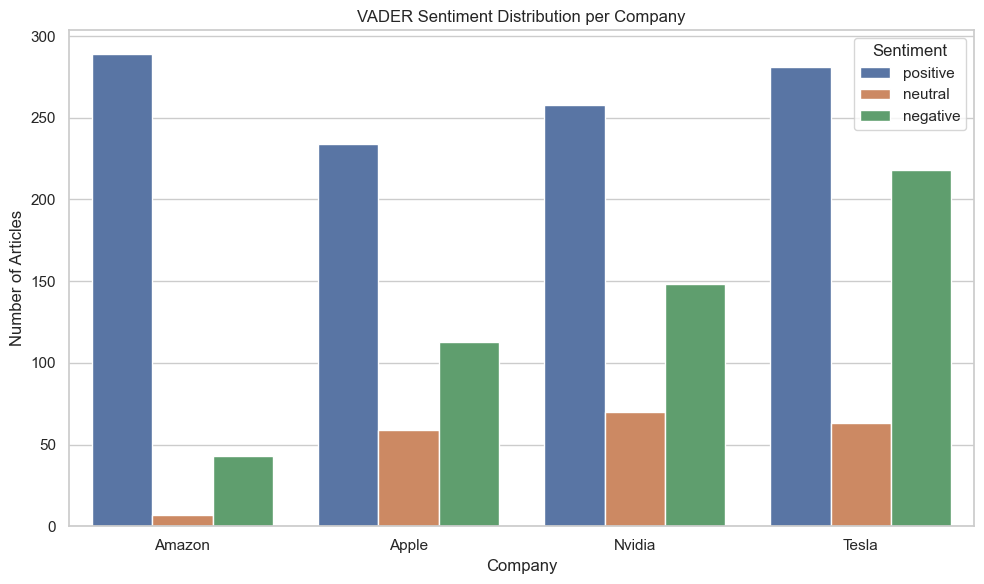

In [17]:


# Set up plot style
sns.set(style="whitegrid")

# Group and count sentiments by company
sentiment_counts = df.groupby(["company", "vader_label"]).size().reset_index(name="count")

# Sort label order
sentiment_order = ["positive", "neutral", "negative"]

# Create bar plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=sentiment_counts,
    x="company",
    y="count",
    hue="vader_label",
    hue_order=sentiment_order
)

plt.title("VADER Sentiment Distribution per Company")
plt.xlabel("Company")
plt.ylabel("Number of Articles")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()


This bar chart displays the distribution of sentiment categories — **positive**, **neutral**, and **negative** — across all four companies based on VADER sentiment scores.

**Insights:**
- All companies show a strong presence of **positive sentiment** in their news coverage.
- **Tesla** and **Nvidia** received the most **negative headlines**, suggesting higher perceived risk or controversy.
- **Amazon** stands out with a very small number of neutral or negative headlines, possibly reflecting a more bullish or less volatile news cycle.
- **Apple** has a moderate distribution across all three sentiment classes.

This helps us understand how media tone varies between companies in the last 90 days and sets a baseline for comparing results with FinBERT next.


## Sentiment Analysis with FinBERT <a id='fin_ana'></a>



To complement VADER, we use **FinBERT**, a transformer-based model trained on financial text. It understands deeper linguistic patterns and domain-specific language better than rule-based tools.

**Why FinBERT?**
- Trained specifically on financial documents
- Can capture subtle nuances (e.g., "missed earnings expectations")
- Outputs one of three labels: **positive**, **neutral**, or **negative**

We'll use the `transformers` library to load the pre-trained model and classify each headline/snippet.


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Load FinBERT model and tokenizer
model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Create sentiment pipeline
finbert = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Test
print(finbert("Apple stock surges after record-breaking earnings"))


ImportError: 
AutoModelForSequenceClassification requires the PyTorch library but it was not found in your environment. Checkout the instructions on the
installation page: https://pytorch.org/get-started/locally/ and follow the ones that match your environment.
Please note that you may need to restart your runtime after installation.


In [52]:
import sys
print(sys.executable)


C:\Users\Mustafa Ansari\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe


In [50]:
import torch
print(torch.__version__)


2.6.0+cpu


In [51]:
import torch
print(torch.__version__)


2.6.0+cpu


In [53]:
print(sys.executable)
!pip show torch
import torch
print(torch.__version__)


C:\Users\Mustafa Ansari\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe
Name: torch
Version: 2.6.0
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: C:\Users\Mustafa Ansari\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages
Requires: filelock, fsspec, jinja2, networkx, sympy, typing-extensions
Required-by: torchaudio, torchvision
2.6.0+cpu
